# Telephone

## Import

In [196]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
from numpy import fft
from matplotlib import pyplot as plt
import csv

fs = 8192
worN = 2048

## Sound of Each Number

### generating sounds

In [107]:
n = np.arange(1000)
omega = {
    "row": [0.5346, 0.5906, 0.6535, 0.7217],
    "col": [0.9273, 1.0247, 1.1328],
}

d = []
for i in range(10):
    virtual_i = i if i else 11
    d.append(np.sin(omega['row'][(virtual_i - 1) // 3] * n) + np.sin(omega['col'][virtual_i % 3 - 1] * n))
    wavfile.write('res/phone/%s.wav' % i, fs, d[i])

### in frequency domain

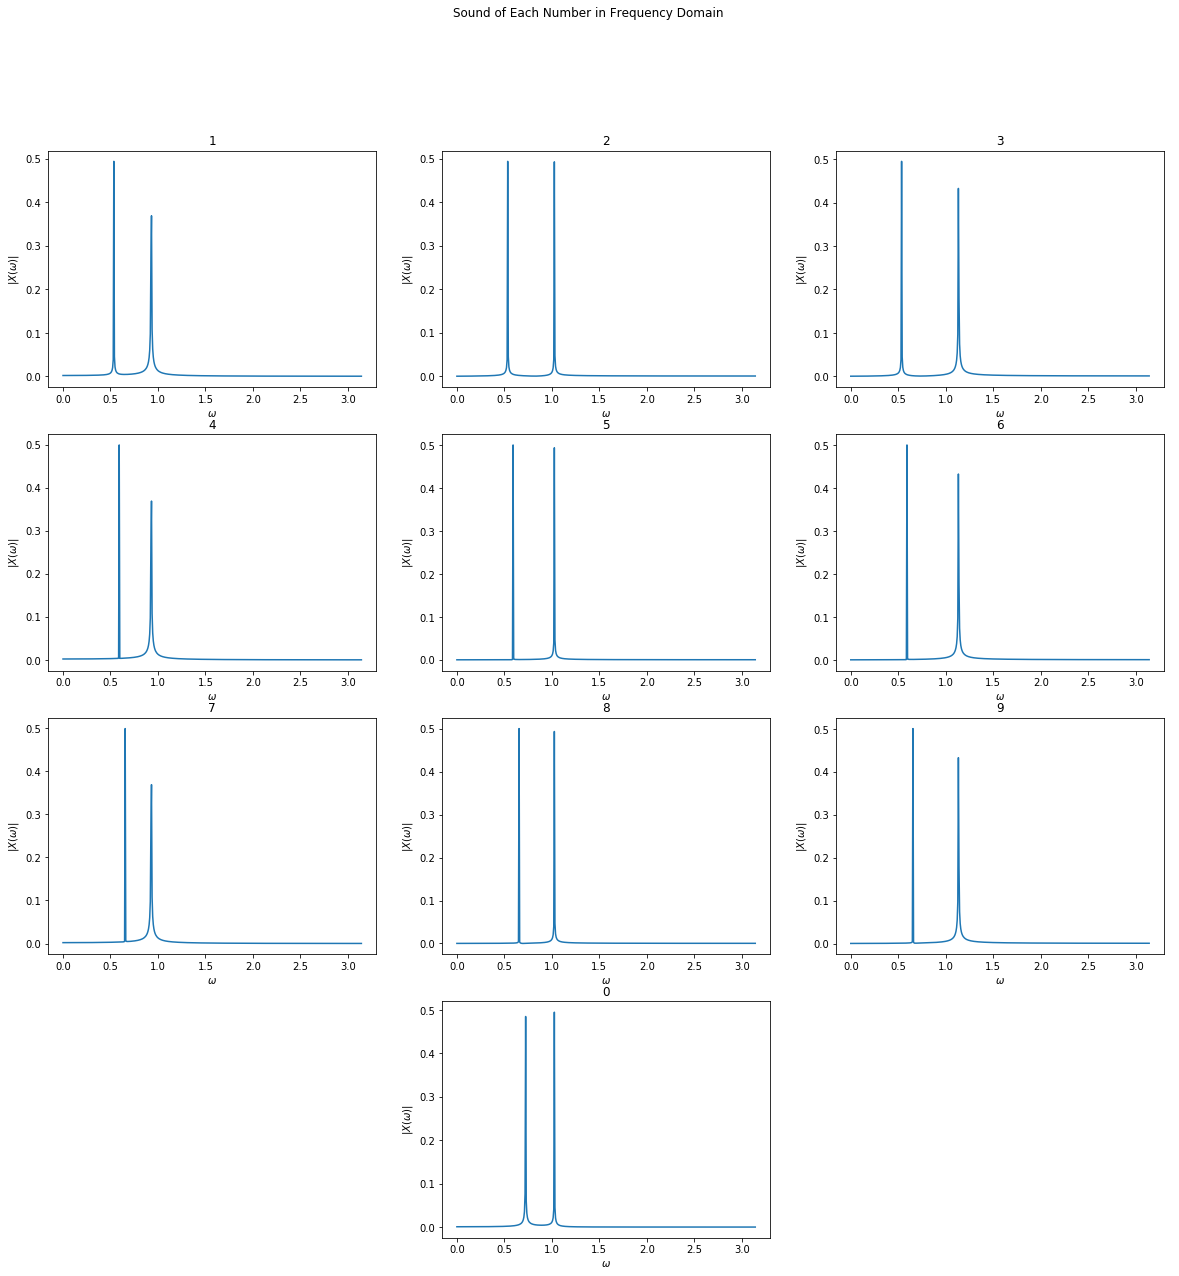

In [216]:
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
fig.suptitle("Sound of Each Number in Frequency Domain")
for i in range(10):
    virtual_i = i if i else 11
    axis = axes[(virtual_i - 1) // 3][virtual_i % 3 - 1]
    axis.plot(np.linspace(0, np.pi, len(d[i]) // 2), np.absolute(fft.fft(d[i]))[:len(d[i]) // 2] / len(d[i]))
    axis.set_title(i)
    axis.set_xlabel(r"$\omega$")
    axis.set_ylabel(r"$|X(\omega)|$")
for i in [10, 12]:
    axes[(i - 1) // 3][i % 3 - 1].axis("off")
plt.show()

## Generating Sound Corresponding to a Number

In [266]:
space = np.zeros(100)

def create_sound_of_number(n):
    return np.concatenate([np.concatenate((d[int(i)], space)) for i in str(n)])

sn = "0194531"
wavfile.write('res/%s.wav' % sn, fs, create_sound_of_number(sn))

In [268]:
wavfile.write('res/number_test.wav', fs, create_sound_of_number(int(input())))

2531000


## Extracting Number from Sound

In [587]:
from math import ceil


def sound_to_digit(sound):
    x_omega_abs = np.absolute(fft.fft(sound))[:len(sound) // 2]
    freq = np.linspace(0, np.pi, len(sound) // 2)[np.where(x_omega_abs > 0.3 * len(sound))]
    row = np.argmin(np.abs(omega['row'] - freq[0]))
#     print("rows: ", np.abs(omega['row'] - freq[0]))
    col = np.argmin(np.abs(omega['col'] - freq[1]))
#     print("cols: ", np.abs(omega['col'] - freq[1]))
    digit = row * 3 + col + 1
#     print("-> ", digit)
    return digit if digit < 10 else 0


def plot_digit(sound, ax, index):
    ax.plot(np.linspace(0, np.pi, len(sound) // 2), np.absolute(fft.fft(sound))[:len(sound) // 2] / len(sound))
    ax.set_title(index)
    ax.set_xlabel(r"$\omega$")
    ax.set_ylabel(r"$|X(\omega)|$")
    ax.axis("on")


def ttdecode(sound, name):
    digits = []
    while len(sound) >= len(d[0]):
        digits.append(sound[:len(d[0])])
        sound = sound[len(d[0]):]
        if len(sound) >= len(space):
            sound = sound[len(space):]
    fig, ax = plt.subplots(ceil(len(digits) / 3), 3, figsize=(13, 13))
    fig.suptitle(name)
    for i in range(ceil(len(digits) / 3) * 3):
        ax[i // 3][i % 3].axis("off")
    for i in range(len(digits)):
        plot_digit(digits[i], ax[i // 3][i % 3], i + 1)
    return "".join([str(sound_to_digit(digit)) for digit in digits])
    plt.show()

phone1:	4915877
phone2:	2531000


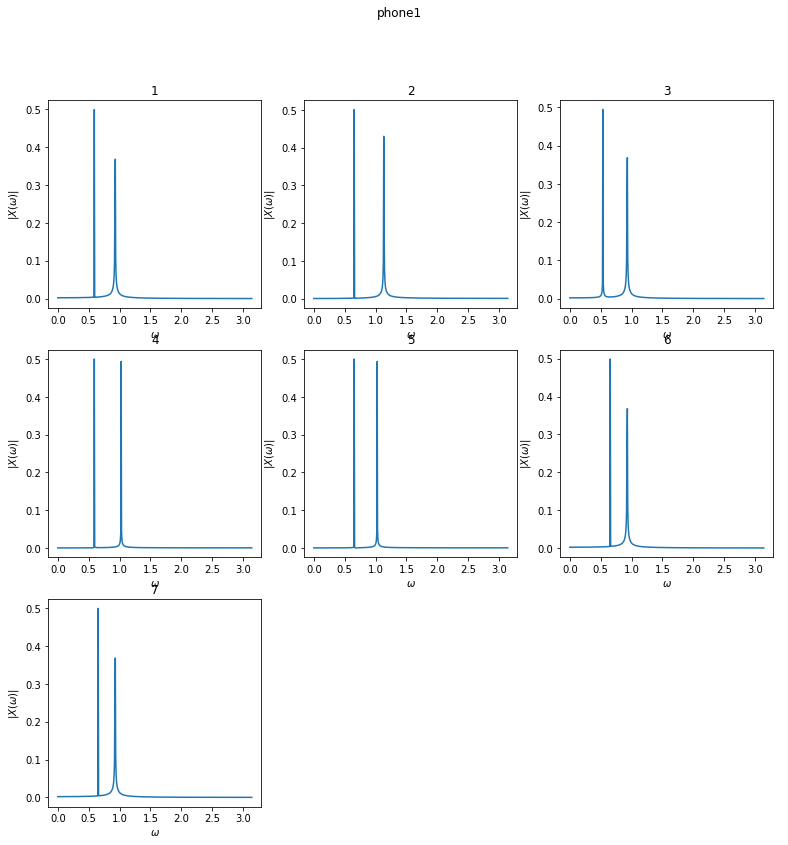

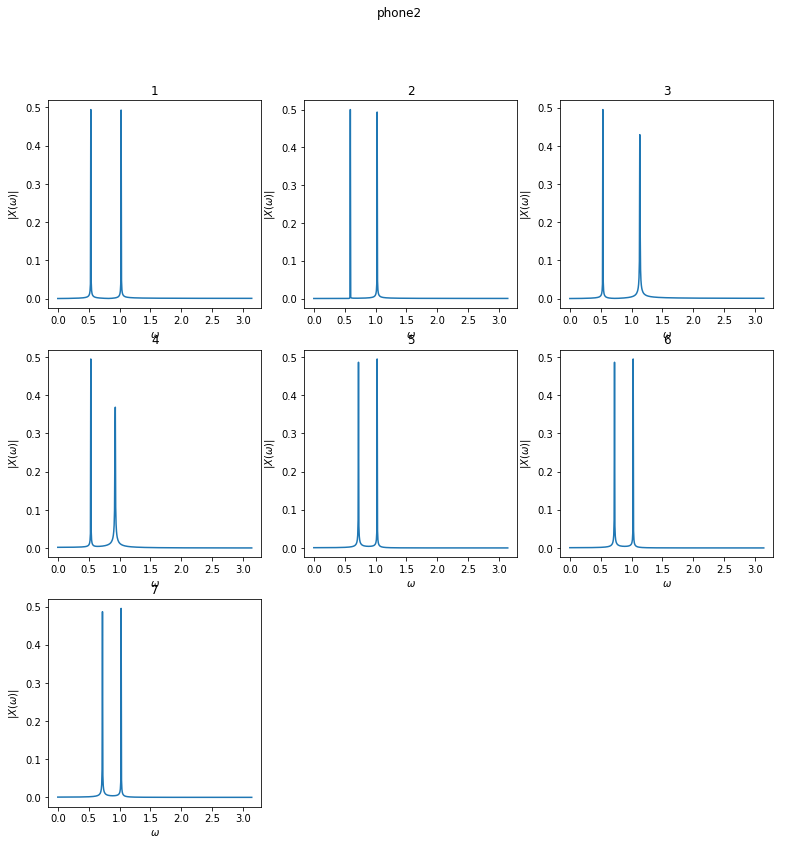

In [588]:
for recorded in ["phone1", "phone2"]:
    with open("res/%s.csv" % recorded) as f:
        sound = np.array(list(csv.reader(f))[0], dtype=np.float64)
    wavfile.write('res/%s.wav' % recorded, fs, sound)
    print("%s:\t%s" % (recorded, ttdecode(sound, recorded)))

### uneuqal length

In [593]:
def get_groups(sound, min_space_lenght=100):
    spaces = np.where(sound == 0)[0]
    space_groups = np.array(np.split(spaces, np.where(np.diff(spaces) != 1)[0] + 1))
    space_groups = space_groups[np.where(np.array([len(i) for i in space_groups]) >= min_space_lenght)]
    space_groups = np.array([(space_group[0], space_group[-1] + 1) for space_group in space_groups])
    groups = np.concatenate(space_groups)
    groups = groups[1:] if 0 in groups else np.concatenate(([0], groups))
    groups = groups[:-1] if len(sound) in groups else np.concatenate((groups, [len(sound)]))
    assert(not (len(groups) % 2))
    groups = np.array([(groups[2 * i], groups[2 * i + 1]) for i in range(len(groups) // 2)])
    return groups


def ttdecode_advanced(sound):
#     for group in get_groups(sound):
#         print(str(sound_to_digit(sound[group[0]:group[1]])), sound[group[0]:group[1]])
    return "".join([str(sound_to_digit(sound[group[0]:group[1]])) for group in get_groups(sound)])


In [594]:
for recorded in ["hard_phone1", "hard_phone2"]:
    with open("res/%s.csv" % recorded) as f:
        sound = np.array(list(csv.reader(f))[0], dtype=np.float64)
    wavfile.write('res/%s.wav' % recorded, fs, sound)
    print("%s:\t%s" % (recorded, ttdecode_advanced(sound)))

hard_phone1:	4915777
hard_phone2:	2431000
